In [ ]:
  #Every time opening this notebook, run this cell and click "Allow".
#May not need to run again after command "restart runtime".
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''Modified on Oct 27th for Matlab PSD Pooled version'''
'''Modified on Oct 25th for 10 band version and Matlab PSD dataset(6 modulations)'''
'''Modified on Sep 27th for 10 band version and larger Testing set'''
'''Generator for Toy Transformer, based on clean_PSD64.pth data (QAM, MSK, GMSK), simplified code
toolboxes may be redundant'''
import csv
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
import time
import heapq

import torch
import os
import math
import torchvision
import torchvision.transforms as transforms
import torch.utils.data.distributed as TUDdistributed
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import sys
from copy import deepcopy
import random
import collections
from scipy import signal
from drive.MyDrive.Wireless_Transformer.PSDshow import imshow
import datetime
import shutil
from pytz import timezone
TMZ = timezone('EST')

In [ ]:
# Refined on Oct27 for randomness
# Load cleanPSD library(dict)
#Set address, either on local(virtual machine) or mounted on drive,
#If mounted to drive and will save the clean PSDs to drive
address = '/content/drive/MyDrive/Wireless_Transformer/'
name = 'clean_PSD_6mod_Mat.pth'
cleanPSD = torch.load(address+name) # load saved clean PSDs
#Check saved PSDs
print(cleanPSD['Description'])

'''Main signal and label list generation, to be finished'''
amp = np.ones(10) #8 # channel gain, currently identical
sig_list = [1,2,3,2,1,4,5,6,5,4] # Sep 9, left&right independent,
num_band = len(sig_list)
assign_dict = {      #bands assigned to each PU
              # Sep9 version, left&right independent
    'description': 'DataSep9,'+name,
    'nPU': 6,
    'PU1': [1,5],
    'PU2': [2,4],
    'PU3': [3],
    'PU4': [6,10],
    'PU5': [7,9],
    'PU6': [8],
        }

# '''Oct24 No-bonding-bands '''
# assign_dict = {      #Oct24 No-bonding-bands
#     'description': 'DataOct24, No-bonding,'+name,
#     'nPU': 10,
#     'PU1': [1],'PU2': [2],'PU3': [3],'PU4': [4],'PU5': [5],'PU6': [6],
#     'PU7':[7], 'PU8':[8], 'PU9':[9], 'PU10':[10],
#         }

def data_generator(volum=1, SNR=10, assign_dict=assign_dict, sig_list=sig_list, PSD_lib=cleanPSD, nw = 64 ):
  '''Oct 27 updated for Matlab data, random PSD
  volum is the num of samples per occupancy pattern,
  SNR (current for single SNR case)
  assign_dict is the PU's band allocation
  sig_list: idx of signal PSDs chosen
  PSD_lib: clean PSDs prepared, w normalized pw '''

  nPU = assign_dict['nPU'] #num of PUs
  db_size_list = [ volum for i in range(2**nPU)] #data volume for different occupancy patterns

  spect_list = []
  label_list = []
  for cls in range(2**nPU): # cls: class of occupancy, decided by active PUs, make "volum" input instances for each cls
    #firstly, generate PSDclean, the input data without noise
    # loop to add random noise to clean PSD with specific occupancy pattern
    for n in range(db_size_list[cls]): # then repeat for examples in "cls" occupancy pattern
      PSDclean = torch.zeros(len(sig_list), nw)
      label = torch.zeros(len(sig_list)) # create empty label tensor

      for PU in range(nPU): #for each PU
        if cls & 2**PU: # if True then this PU active
          for band_idx in assign_dict['PU'+str(PU+1)]: # band list assigned to this PU
            label[band_idx-1] = 1 #set label
            PSD_LMR = PSD_lib[sig_list[band_idx-1]][  random.randrange(10)  ]#randomly pick a PSD of this mod, contain left/right leakage
            PSD_L=torch.tensor(PSD_LMR[0:64])
            PSD_M=torch.tensor(PSD_LMR[64:128])
            PSD_R=torch.tensor(PSD_LMR[-64:192])
            PSDclean[band_idx-1] += torch.squeeze(PSD_M)#take the middle 64 digits
            if band_idx>1: #if not left edge
              PSDclean[band_idx-2] += torch.squeeze(PSD_L)
            if band_idx<len(sig_list): #if not right edge
              PSDclean[band_idx] += torch.squeeze(PSD_R)

      label_list.append(label) # prepare labels for the same occupy cls
      spect_list.append( torch.abs( PSDclean + torch.randn_like(PSDclean)*10**(-1*SNR/10) ).view(nw*len(sig_list)) )

  return (spect_list, label_list)

def setDir(filepath):
  # if directory not exist, create. if directory already exist, empty it.
  if not os.path.exists(filepath):
    os.makedirs(filepath)
  else:
    shutil.rmtree(filepath, ignore_errors = True)
    os.makedirs(filepath)

from Matlab, PSD of 6 narrowband sig (4 PSKs, FSK, QAM), length =64, type is 1D numpy ndarray tensor. each key has a list of 10 set 192-dim PSDs


In [ ]:
# No PowerLeakage version
address = '/content/drive/MyDrive/Wireless_Transformer/'
name = 'clean_PSD_6mod_Mat.pth'
cleanPSD = torch.load(address+name) # load saved clean PSDs
#Check saved PSDs
print(cleanPSD['Description'])

assign_dict = {      #bands assigned to each PU
              # Sep9 version, left&right independent
    'description': 'DataSep9,'+name,
    'nPU': 6,
    'PU1': [1,5],
    'PU2': [2,4],
    'PU3': [3],
    'PU4': [6,10],
    'PU5': [7,9],
    'PU6': [8],
        }


'''Main signal and label list generation, to be finished'''
amp = np.ones(10) #8 # channel gain, currently identical
sig_list = [1,2,3,2,1,4,5,6,5,4] # Sep 9, left&right independent,
num_band = len(sig_list)
assign_dict = {      #bands assigned to each PU
              # Sep9 version, left&right independent
    'description': 'DataSep9,'+name,
    'nPU': 6,
    'PU1': [1,5],
    'PU2': [2,4],
    'PU3': [3],
    'PU4': [6,10],
    'PU5': [7,9],
    'PU6': [8],
        }

# '''Oct24 No-bonding-bands '''
# assign_dict = {      #Oct24 No-bonding-bands
#     'description': 'DataOct24, No-bonding,'+name,
#     'nPU': 10,
#     'PU1': [1],'PU2': [2],'PU3': [3],'PU4': [4],'PU5': [5],'PU6': [6],
#     'PU7':[7], 'PU8':[8], 'PU9':[9], 'PU10':[10],
#         }

def data_generator(volum=1, SNR=10, assign_dict=assign_dict, sig_list=sig_list, PSD_lib=cleanPSD, nw = 64 ):
  '''Oct 27 updated for Matlab data, random PSD
  volum is the num of samples per occupancy pattern,
  SNR (current for single SNR case)
  assign_dict is the PU's band allocation
  sig_list: idx of signal PSDs chosen
  PSD_lib: clean PSDs prepared, w normalized pw '''

  nPU = assign_dict['nPU'] #num of PUs
  db_size_list = [ volum for i in range(2**nPU)] #data volume for different occupancy patterns

  spect_list = []
  label_list = []
  for cls in range(2**nPU): # cls: class of occupancy, decided by active PUs, make "volum" input instances for each cls
    #firstly, generate PSDclean, the input data without noise
    # loop to add random noise to clean PSD with specific occupancy pattern
    for n in range(db_size_list[cls]): # then repeat for examples in "cls" occupancy pattern
      PSDclean = torch.zeros(len(sig_list), nw)
      label = torch.zeros(len(sig_list)) # create empty label tensor

      for PU in range(nPU): #for each PU
        if cls & 2**PU: # if True then this PU active
          for band_idx in assign_dict['PU'+str(PU+1)]: # band list assigned to this PU
            label[band_idx-1] = 1 #set label
            PSD_LMR = PSD_lib[sig_list[band_idx-1]][  random.randrange(10)  ]#randomly pick a PSD of this mod, contain left/right leakage
            # PSD_L=torch.tensor(PSD_LMR[0:64])
            PSD_M=torch.tensor(PSD_LMR[64:128])
            # PSD_R=torch.tensor(PSD_LMR[-64:192])
            PSDclean[band_idx-1] += torch.squeeze(PSD_M)#take the middle 64 digits

      label_list.append(label) # prepare labels for the same occupy cls
      spect_list.append( torch.abs( PSDclean + torch.randn_like(PSDclean)*10**(-1*SNR/10) ).view(nw*len(sig_list)) )

  return (spect_list, label_list)

def setDir(filepath):
  # if directory not exist, create. if directory already exist, empty it.
  if not os.path.exists(filepath):
    os.makedirs(filepath)
  else:
    shutil.rmtree(filepath, ignore_errors = True)
    os.makedirs(filepath)

from Matlab, PSD of 6 narrowband sig (4 PSKs, FSK, QAM), length =64, type is 1D numpy ndarray tensor. each key has a list of 10 set 192-dim PSDs


dataset saved to: /content/drive/MyDrive/Wireless_Transformer/RefinedNewData/testing/231219_20_04Data_SNR5vol10.pth


<ipython-input-5-3bb2035853a8>:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20, 2), dpi=80)


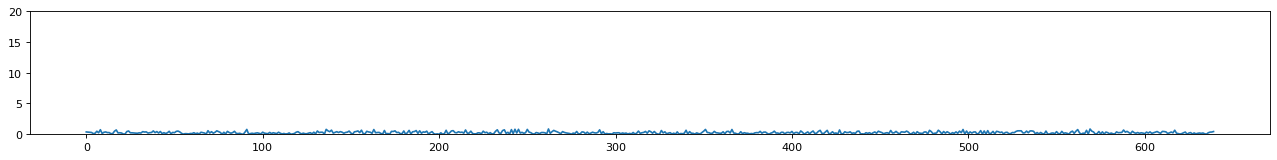

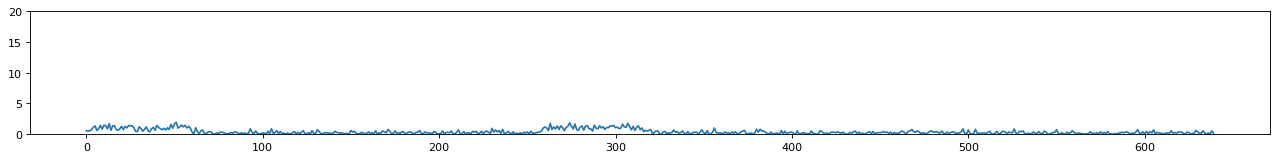

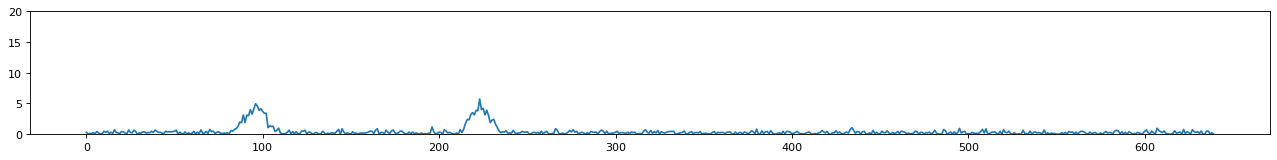

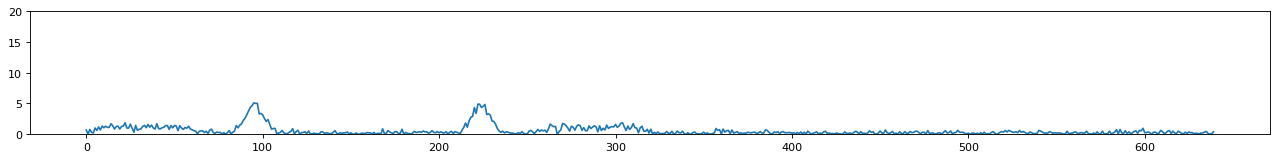

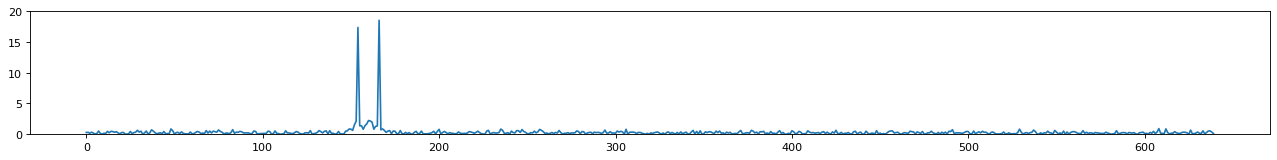

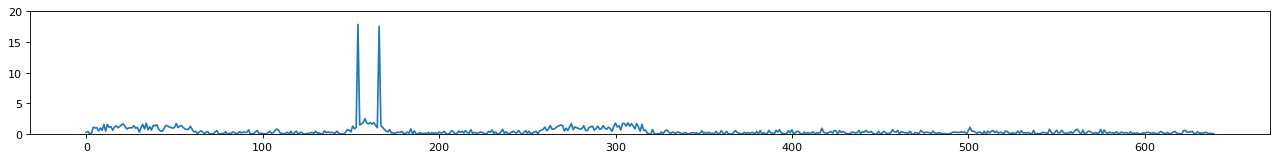

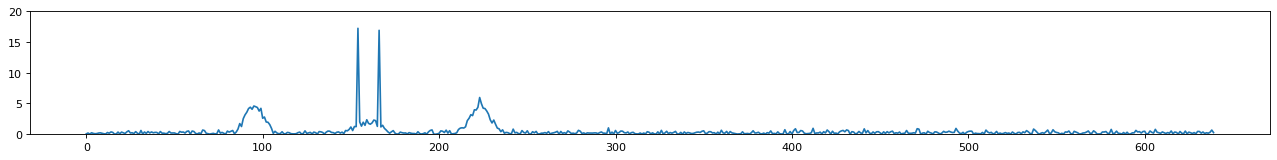

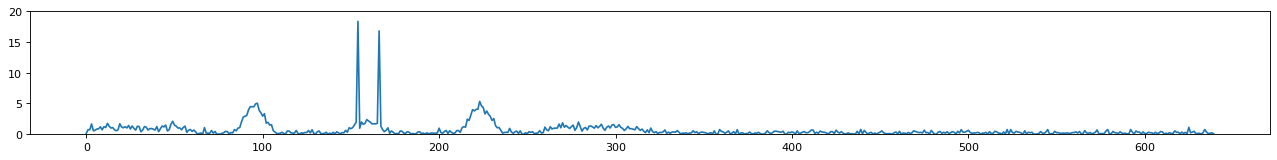

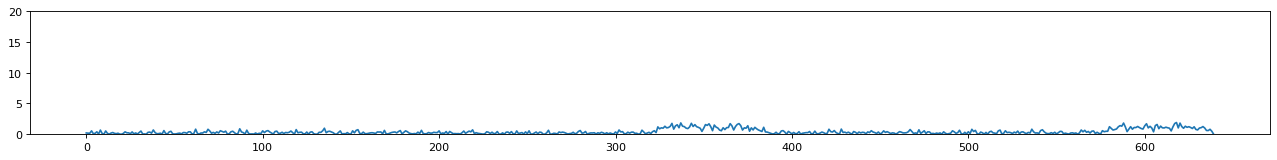

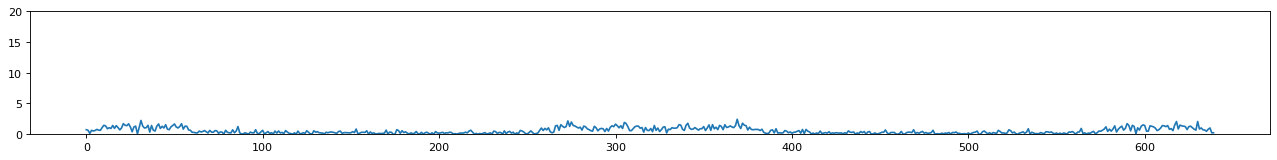

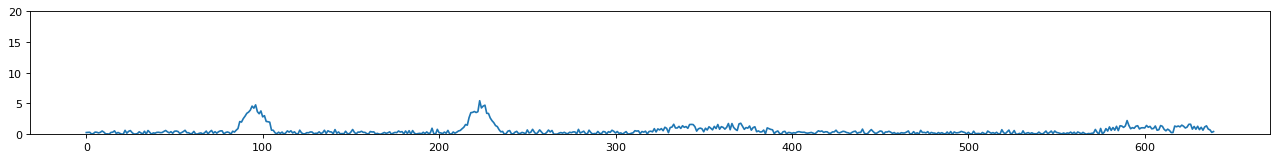

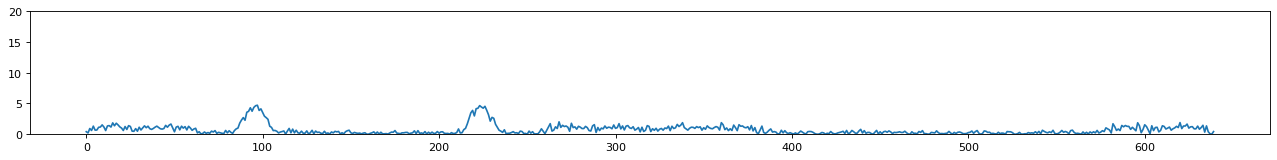

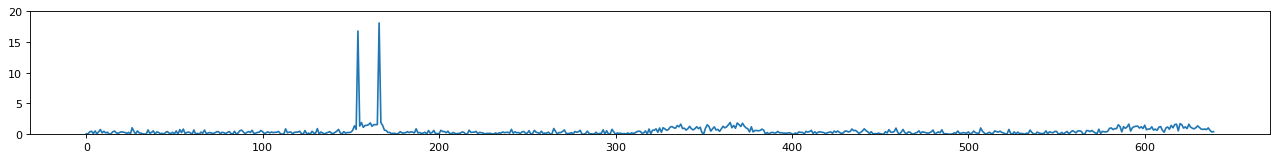

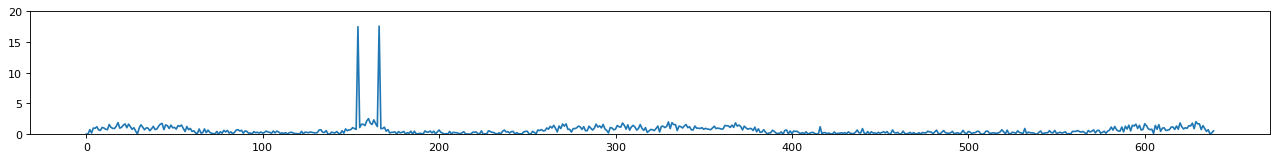

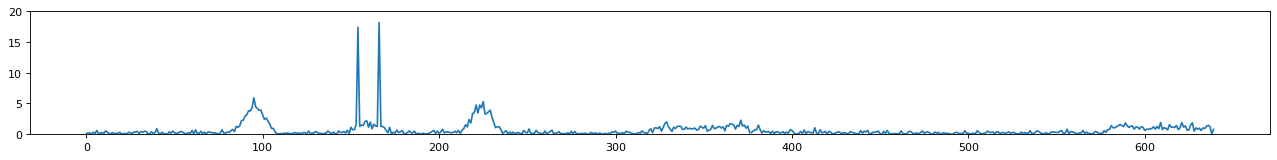

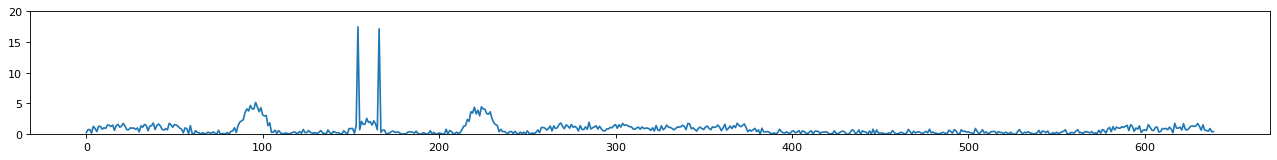

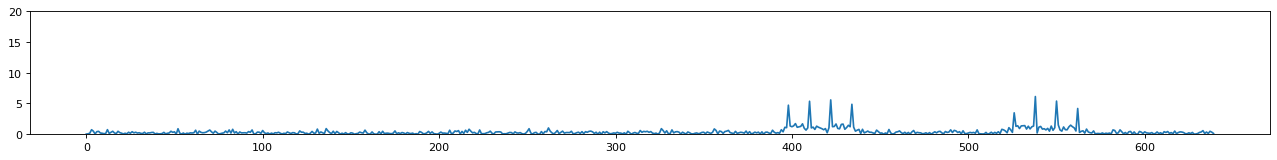

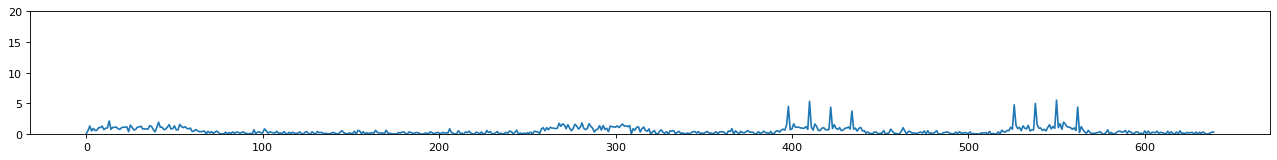

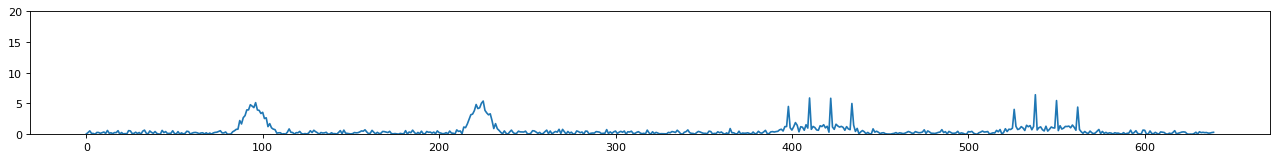

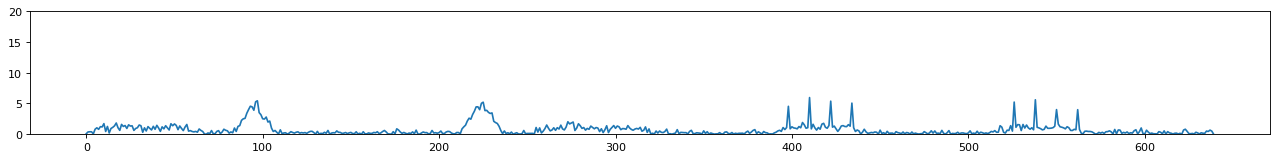

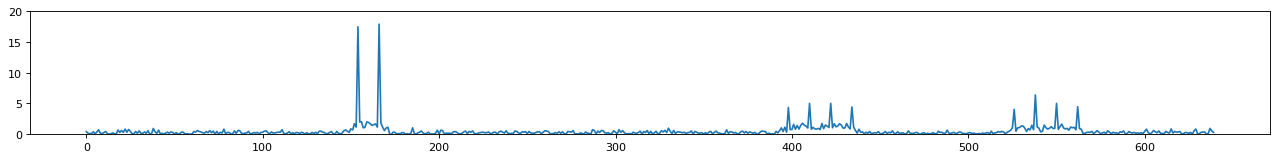

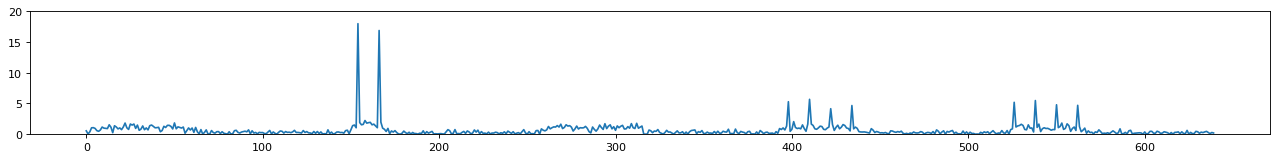

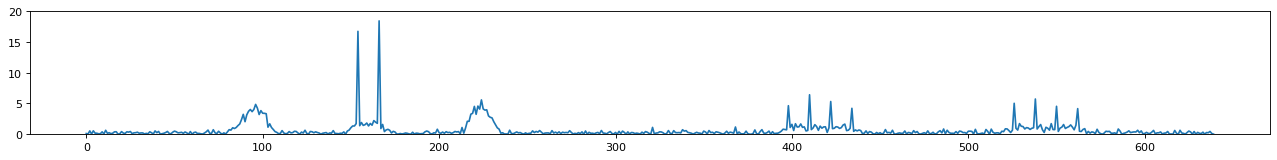

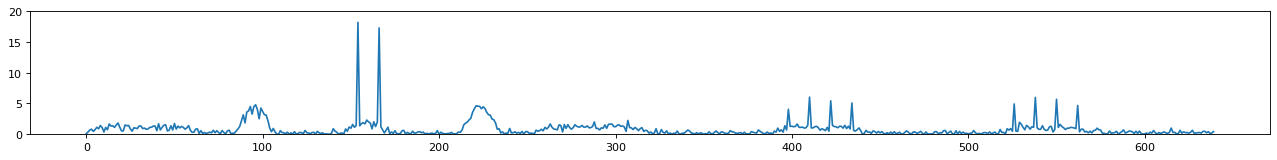

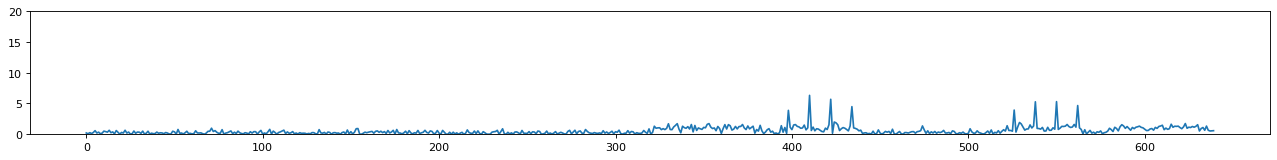

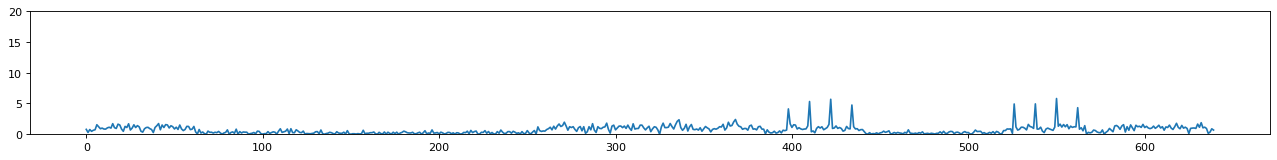

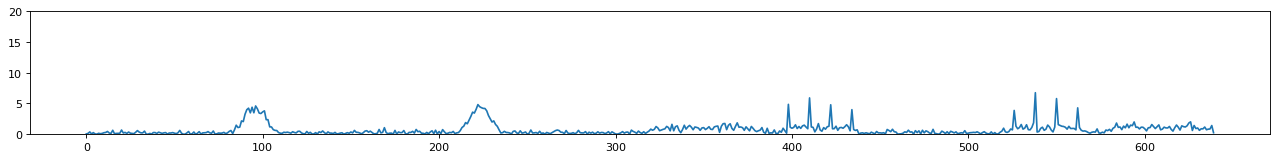

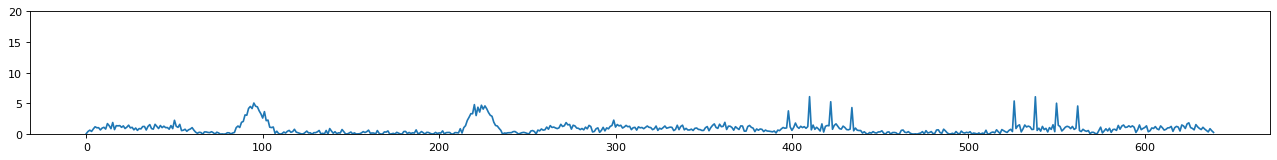

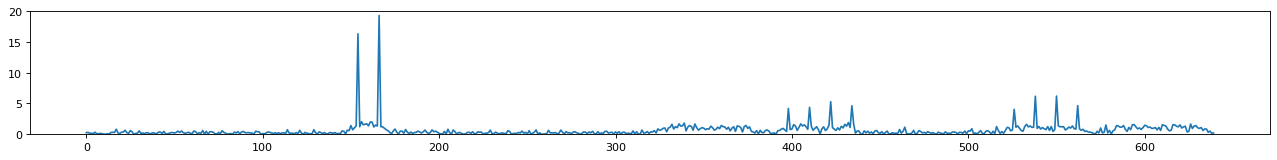

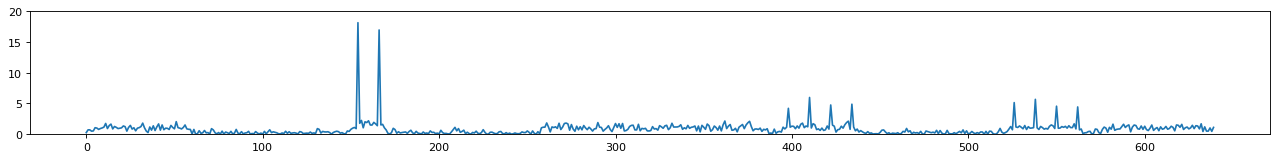

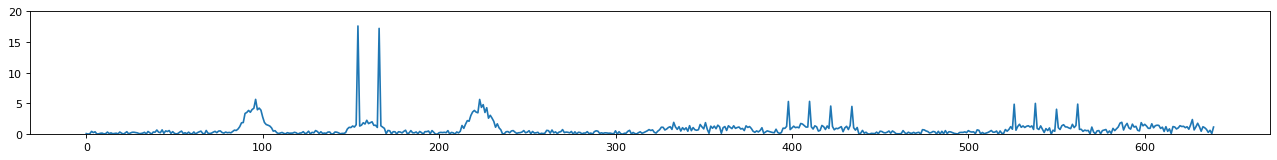

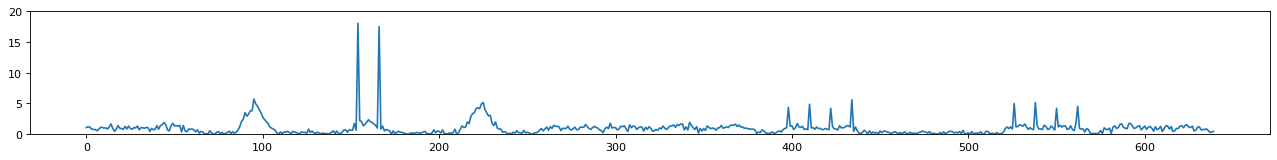

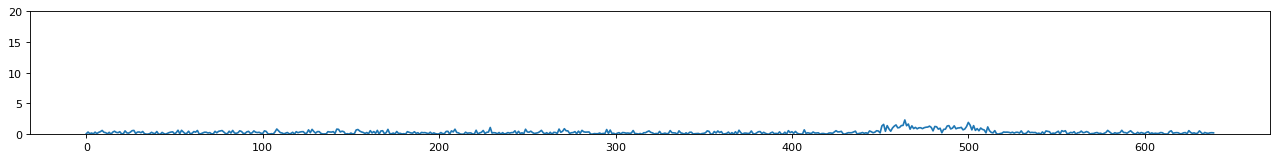

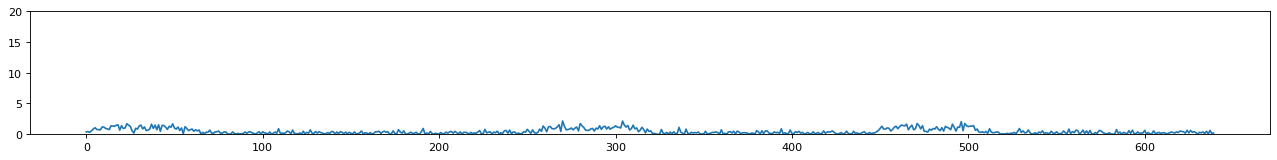

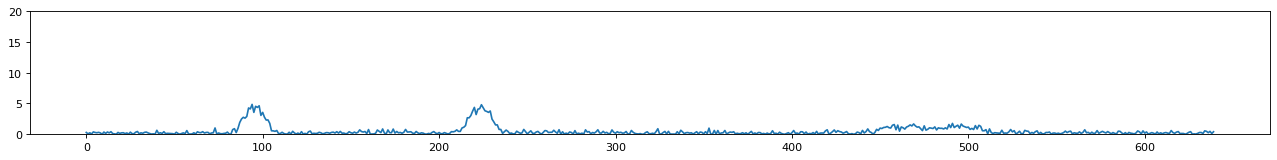

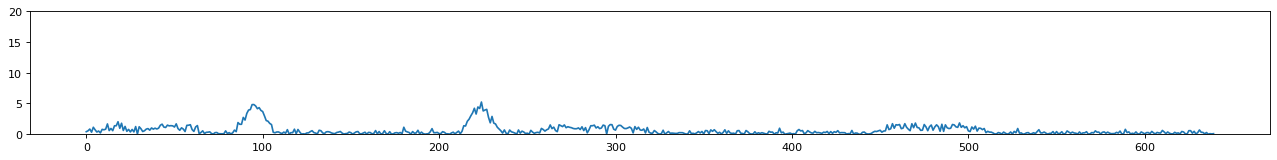

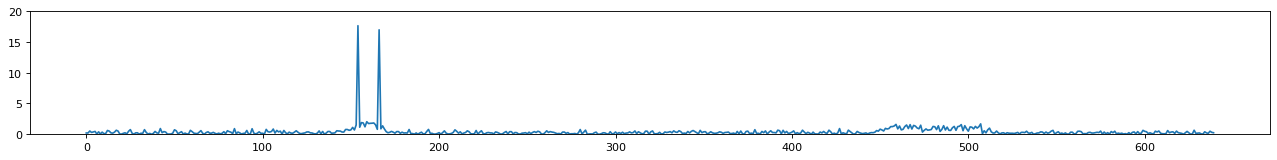

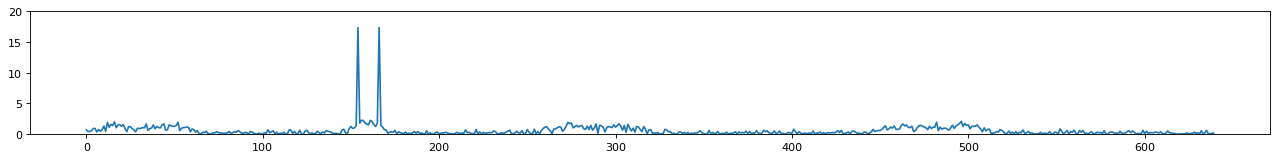

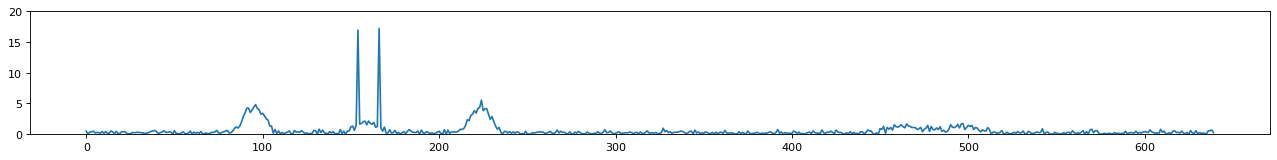

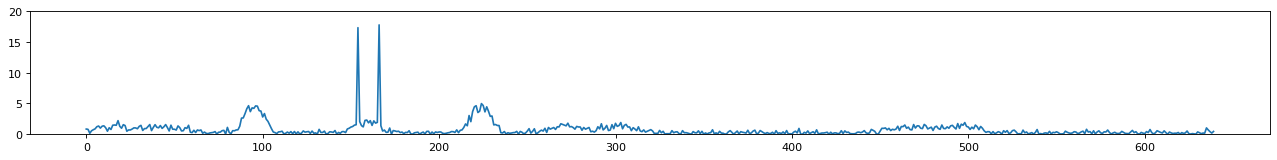

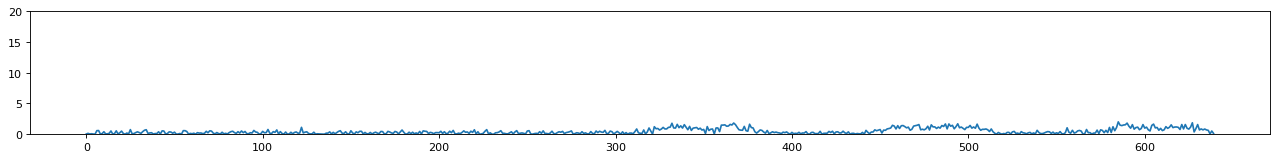

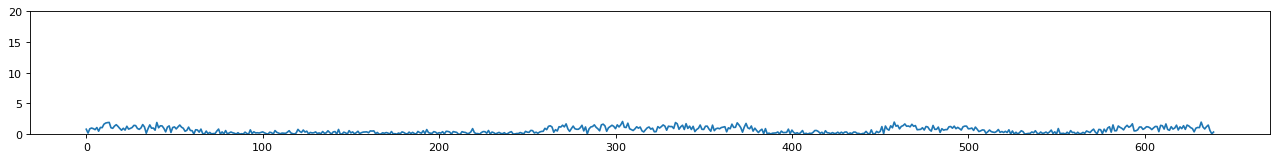

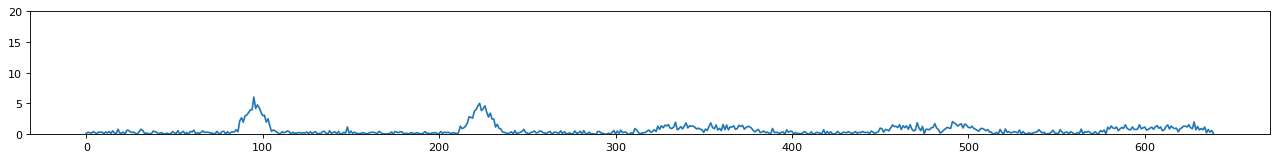

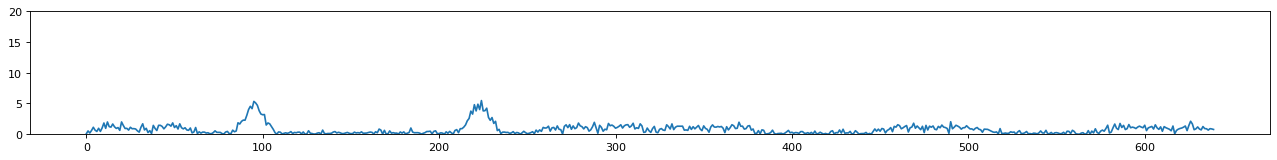

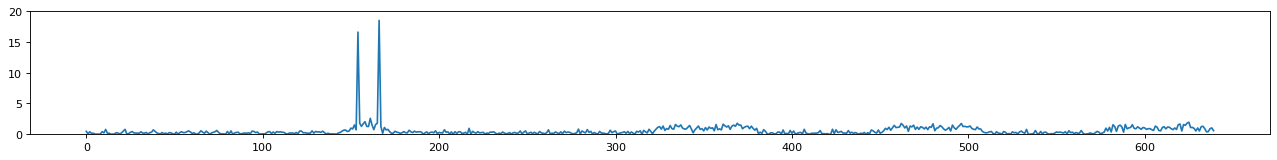

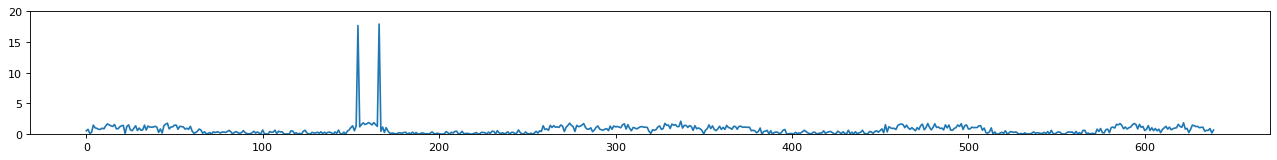

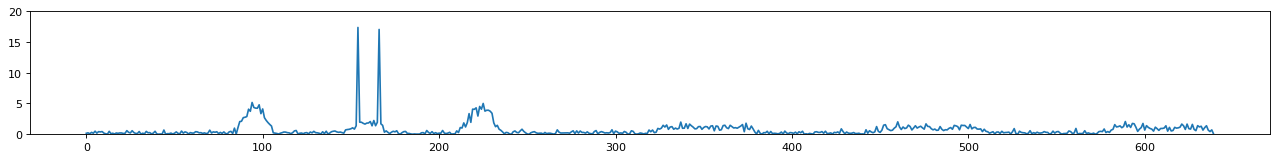

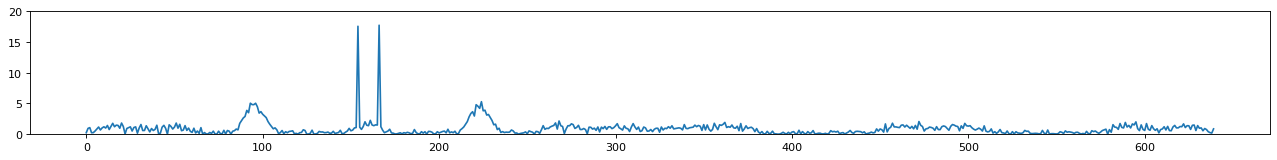

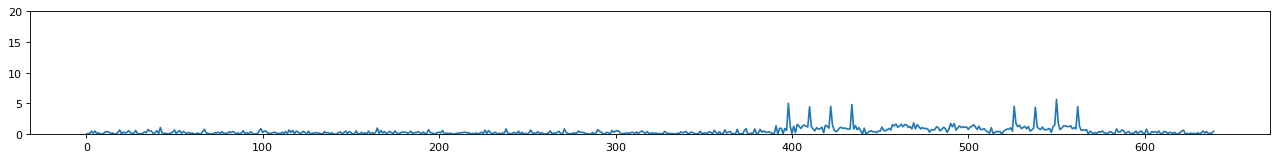

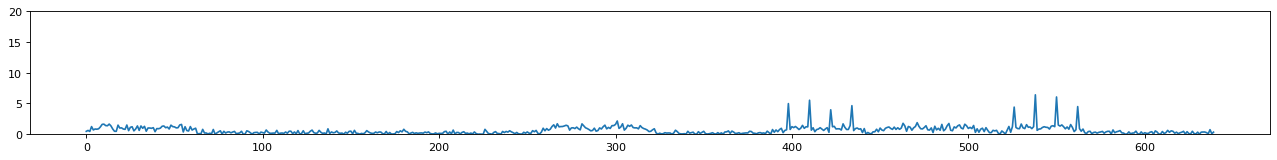

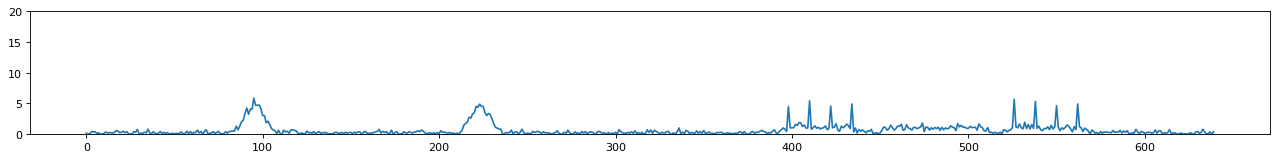

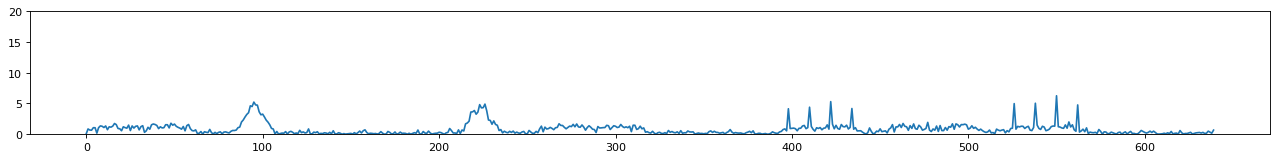

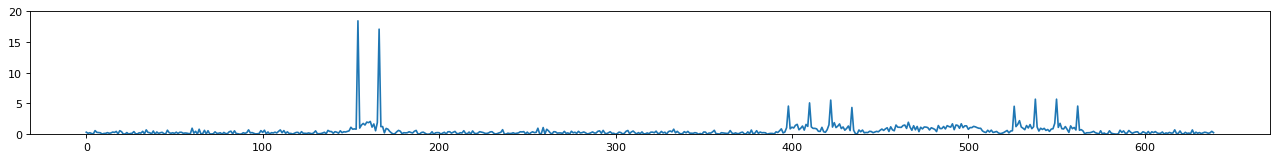

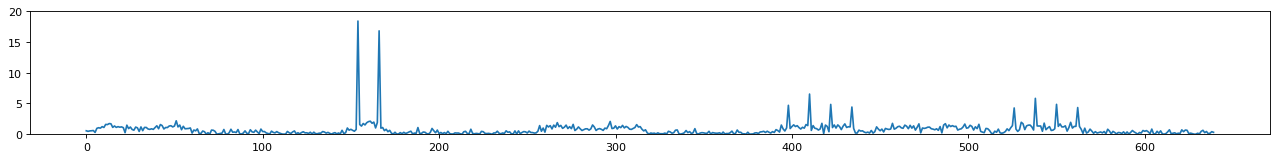

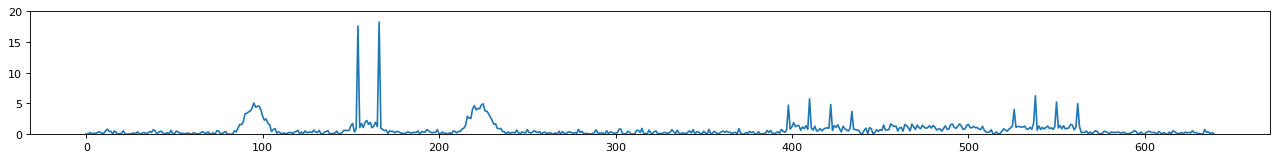

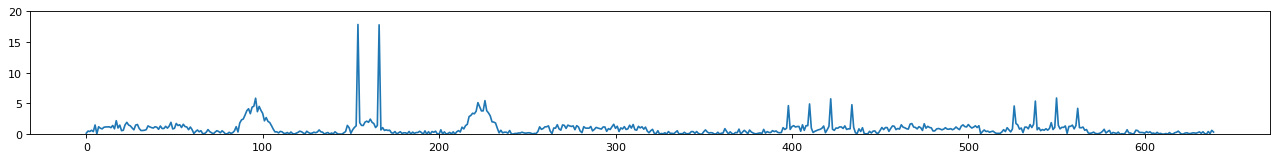

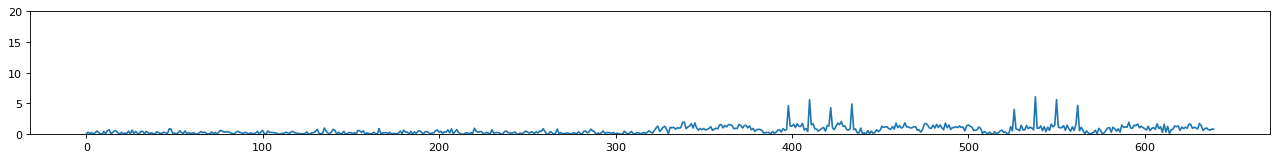

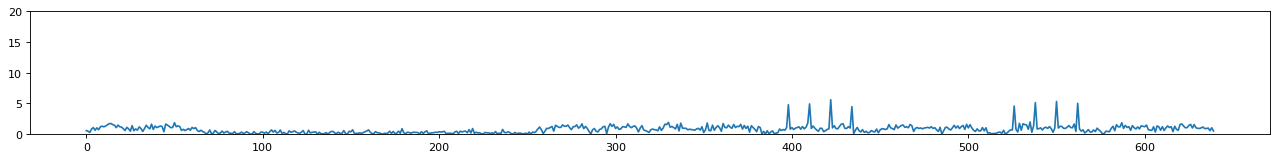

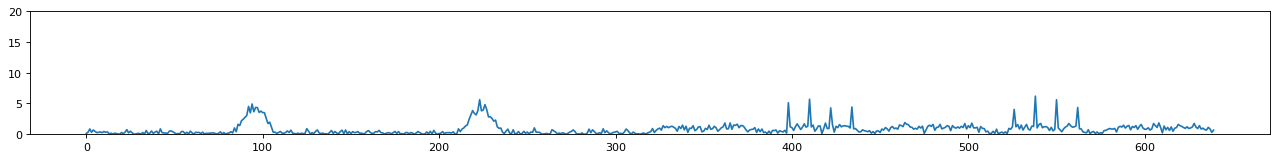

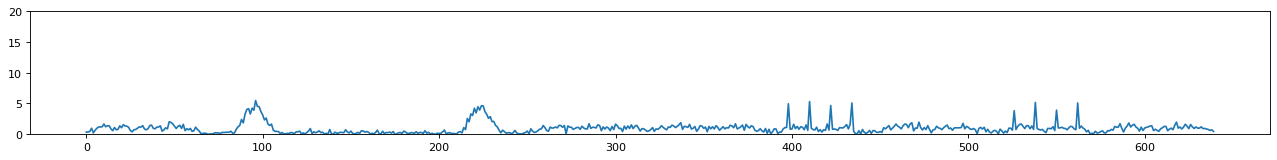

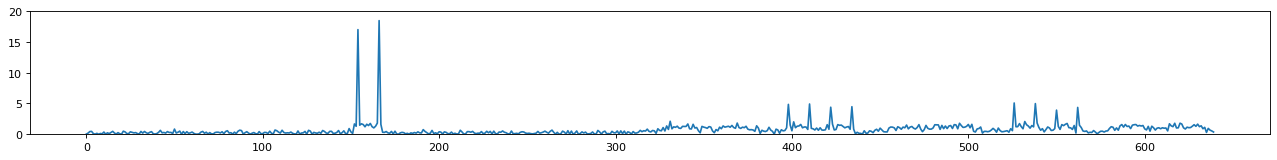

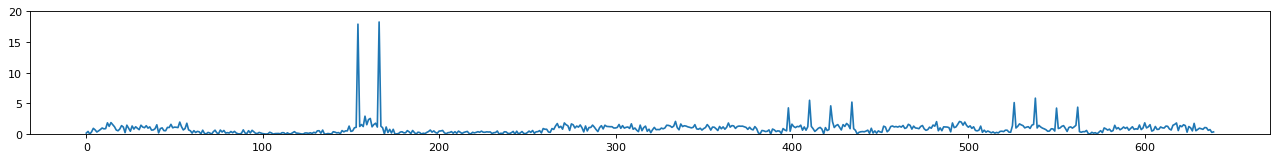

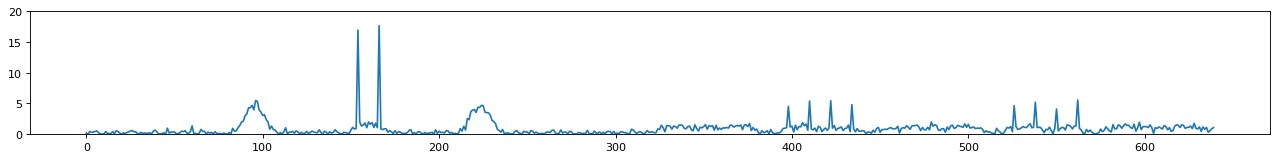

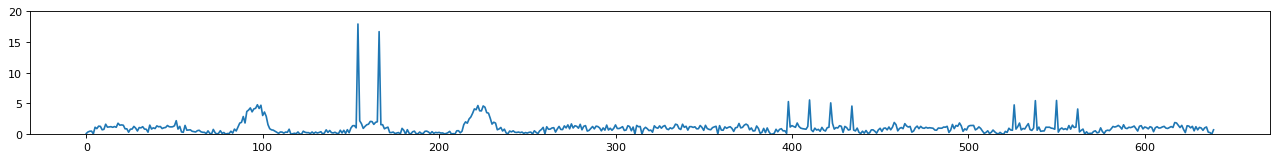

In [ ]:
'''For debugging code functioning'''
'''Generate, save and show fully occupied data for a specific SNR'''

SNR = 5 # 5 20
volum = 10 #1000
nw = 64 #bandwidth of each band or freq resolution in pts
now=datetime.datetime.now()
time_watermark = now.strftime('%y%m%d_%H_%M')
datas_tr, labels_tr = data_generator(volum=volum, SNR=SNR, assign_dict=assign_dict, sig_list=sig_list, PSD_lib=cleanPSD, nw = nw)
datas_te, labels_te = data_generator(volum=volum//10, SNR=SNR, assign_dict=assign_dict, sig_list=sig_list, PSD_lib=cleanPSD, nw = nw)
db = {
    'Description': 'cleanPSD64.pth, SNR'+str(SNR)+'dB, '+str(len(sig_list))+'bands, '+str(assign_dict['nPU'])+'PUs, '+str(nw)+'pts/band.',
    'training data list': datas_tr,
    'training label list': labels_tr,
    'testing data list': datas_te,
    'testing label list': labels_te,
    'sig_list': sig_list,
    'assign_dict': assign_dict,
    'time':'TBD',
}

address1 = '/content/drive/MyDrive/Wireless_Transformer/RefinedNewData/testing/'
setDir(address1)
name1 = time_watermark+'Data_SNR'+str(SNR)+'vol'+str(volum)+'.pth' #W/O time watermark child dir
db['time'] = time_watermark # apply watermark to db dict
torch.save(db, address1 + name1)
print('dataset saved to: '+address1+name1)

'''load and plot PSD figure for all full occupancy'''
datadict = torch.load(address1 + name1)
datas_tr = datadict['training data list']

# for spec in datas_tr[-10: -1]: # plot the last sample: fully occupied
for spec in datas_te:
  sample = spec.view(int(num_band*nw))
  xaxis = np.arange(0, int(num_band*nw), dtype =  float)# set x axis
  plt.figure(figsize=(20, 2), dpi=80)
  plt.plot(xaxis, sample) #linear scale
  plt.ylim(0, 20)
  # plt.plot(xaxis, 10*np.log10(sample)) #dB scale
  # print('db time watermark '+ db['time'])

In [ ]:
for idx in range(len(datas_te)):
  font_size = 14
  # if idx == 63: #1: #idx == 63:
  if 1:
    spec = datas_te[idx]
    sample = spec.view(int(num_band*nw))
    xaxis = np.arange(0, int(num_band*nw), dtype =  float)# set x axis
    plt.figure(figsize=(20, 4), dpi=80)
    # plt.plot(xaxis, sample) #linear scale

    # plt.plot(xaxis, 10*np.log10(sample)) #dB scale
    # plt.plot( 10*np.log10(sample)-60) #dB scale
    plt.plot(np.arange(950, 1050, 100/640), 10*np.log10(sample)-120) #dBm/Hz scale, assume -50dBm total pw in a 10MHz band
    plt.ylabel("Power Spectrum Density\n (dBm/Hz)", fontsize=font_size+4)
    plt.xlabel("Frequency (MHz)", fontsize=font_size+4)
    # plt.xticks(np.arange(0, 704, 64))
    plt.xticks(np.arange(950, 1051, 10), fontsize=font_size)
    plt.yticks(np.arange(-130, -100, 10), fontsize=font_size)
    # plt.ylim(-70, -40)
    plt.ylim(-140, -100)
    plt.xlim(950, 1050)
    # print('db time watermark '+ db['time'])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
np.arange(950, 1051, 10)

array([ 950,  960,  970,  980,  990, 1000, 1010, 1020, 1030, 1040, 1050])

In [ ]:
'For data made&loaded in prev cell, loop to show all occupancy figs(testset)'
datas_te = datadict['testing data list']
for i in range(2**assign_dict['nPU']):
  print(i)
  sample = datas_te[i].view(int(num_band*nw)) # for each occupancy class take one to plot
  xaxis = np.arange(0, int(num_band*nw), dtype =  float)# set x axis
  plt.figure(figsize=(16, 2), dpi=80)
  plt.plot(xaxis, sample)
  plt.ylim(0, 8)
  # plt.axis()

In [ ]:
'''Loop for generating data with a range of SNR, modified from 'Generate and save data for specific SNR' '''
# invsnr_list = [1,3,5,7,9,11,13,15] #dB
# invsnr_list = list(range(11)) # quick version for prelim test
 #testing a few SNR
# invsnr_list =
now=datetime.datetime.now(TMZ)
time_watermark = now.strftime('%y%m%d_%H_%M')
nw=64

invsnr_list = [4,6,8,0,2,10,1,3, -1, -2]
volum = 100 #250 #1000
address1 = '/content/drive/MyDrive/Wireless_Transformer/RefinedNewData/SmalldataNoPWLK/' # unbonded data, use volum=250

# invsnr_list = [4,6,8,0,2,10]
# address1 = '/content/drive/MyDrive/Wireless_Transformer/RefinedNewData/' #root dir for refined data
# volum = 4000
# address1 = '/content/drive/MyDrive/Wireless_Transformer/RefinedNewData/noleakage/' # unbonded data, use volum=4000
save_dir=address1+time_watermark+'/' #child dir nbamed by time_watermark
setDir(save_dir)

assign_dict = {      #bands assigned to each PU
              # Sep9 version, left&right independent
    'description': 'DataSep9,'+name,
    'nPU': 6,
    'PU1': [1,5],
    'PU2': [2,4],
    'PU3': [3],
    'PU4': [6,10],
    'PU5': [7,9],
    'PU6': [8],
        }

for snr in invsnr_list:
  SNR = snr*(-1) # 0 to -10dB
  print('Start to generate the',str(SNR),'dB data ')
  datas_tr, labels_tr = data_generator(volum=volum, SNR=SNR, assign_dict=assign_dict, sig_list=sig_list, PSD_lib=cleanPSD, nw = nw)
  datas_te, labels_te = data_generator(volum=volum//10, SNR=SNR, assign_dict=assign_dict, sig_list=sig_list, PSD_lib=cleanPSD, nw = nw)
  db = {
      'Description': 'cleanPSD64.pth, SNR'+str(SNR)+'dB, '+str(len(sig_list))+'bands, '+str(assign_dict['nPU'])+'PUs, '+str(nw)+'pts/band.',
      'training data list': datas_tr,
      'training label list': labels_tr,
      'testing data list': datas_te,
      'testing label list': labels_te,
      'sig_list': sig_list,
      'assign_dict': assign_dict,
      'time':'TBD',
  }
  db['time'] = time_watermark
  name1 = 'Data_SNR'+str(SNR)+'vol'+str(volum)+'.pth'
  torch.save(db, save_dir+ name1)
  print('Data saved to: \n', save_dir+ name1)

Start to generate the -4 dB data 
Data saved to: 
 /content/drive/MyDrive/Wireless_Transformer/RefinedNewData/SmalldataNoPWLK/221210_23_08/Data_SNR-4vol100.pth
Start to generate the -6 dB data 
Data saved to: 
 /content/drive/MyDrive/Wireless_Transformer/RefinedNewData/SmalldataNoPWLK/221210_23_08/Data_SNR-6vol100.pth
Start to generate the -8 dB data 
Data saved to: 
 /content/drive/MyDrive/Wireless_Transformer/RefinedNewData/SmalldataNoPWLK/221210_23_08/Data_SNR-8vol100.pth
Start to generate the 0 dB data 
Data saved to: 
 /content/drive/MyDrive/Wireless_Transformer/RefinedNewData/SmalldataNoPWLK/221210_23_08/Data_SNR0vol100.pth
Start to generate the -2 dB data 
Data saved to: 
 /content/drive/MyDrive/Wireless_Transformer/RefinedNewData/SmalldataNoPWLK/221210_23_08/Data_SNR-2vol100.pth
Start to generate the -10 dB data 
Data saved to: 
 /content/drive/MyDrive/Wireless_Transformer/RefinedNewData/SmalldataNoPWLK/221210_23_08/Data_SNR-10vol100.pth
Start to generate the -1 dB data 
Data s

In [ ]:
'''Loop for generating data with a range of volums '''
SNR = -6
now=datetime.datetime.now(TMZ)
time_watermark = now.strftime('%y%m%d_%H_%M')
nw=64
volum_list = [50, 20] #[400, 200, 100]
# volum_list = [800, 400, 200]
address1 = '/content/drive/MyDrive/Wireless_Transformer/RefinedNewData/varyingsize/' #root dir for refined data
save_dir=address1+time_watermark+'/' #child dir nbamed by time_watermark
setDir(save_dir)
assign_dict = {      #bands assigned to each PU
              # Sep9 version, left&right independent
    'description': 'DataSep9,'+name,
    'nPU': 6,
    'PU1': [1,5],
    'PU2': [2,4],
    'PU3': [3],
    'PU4': [6,10],
    'PU5': [7,9],
    'PU6': [8],
        }

for volum in volum_list:
  print('Start to generate the',str(SNR),'dB ',str(volum),' data.')
  datas_tr, labels_tr = data_generator(volum=volum, SNR=SNR, assign_dict=assign_dict, sig_list=sig_list, PSD_lib=cleanPSD, nw = nw)
  datas_te, labels_te = data_generator(volum=volum//10, SNR=SNR, assign_dict=assign_dict, sig_list=sig_list, PSD_lib=cleanPSD, nw = nw)
  db = {
      'Description': 'cleanPSD64.pth, SNR'+str(SNR)+'dB, '+str(len(sig_list))+'bands, '+str(assign_dict['nPU'])+'PUs, '+str(nw)+'pts/band.',
      'training data list': datas_tr,
      'training label list': labels_tr,
      'testing data list': datas_te,
      'testing label list': labels_te,
      'sig_list': sig_list,
      'assign_dict': assign_dict,
      'time':'TBD',
  }
  db['time'] = time_watermark
  name1 = 'Data_SNR'+str(SNR)+'vol'+str(volum)+'.pth'
  torch.save(db, save_dir+ name1)
  print('Data saved to: \n', save_dir+ name1)

Start to generate the -6 dB  50  data.
Data saved to: 
 /content/drive/MyDrive/Wireless_Transformer/RefinedNewData/varyingsize/221209_15_08/Data_SNR-6vol50.pth
Start to generate the -6 dB  20  data.
Data saved to: 
 /content/drive/MyDrive/Wireless_Transformer/RefinedNewData/varyingsize/221209_15_08/Data_SNR-6vol20.pth


In [ ]:
''' for Unbond data, need assign_dict, generating data with a range of SNR,'''
# invsnr_list = [1,3,5,7,9,11,13,15] #dB
# invsnr_list = list(range(11)) # quick version for prelim test
 #testing a few SNR
# invsnr_list =
now=datetime.datetime.now(TMZ)
time_watermark = now.strftime('%y%m%d_%H_%M')
nw=64

'''Oct24 No-bonding-bands '''
assign_dict = {      #Oct24 No-bonding-bands
    'description': 'DataOct24, No-bonding,'+name,
    'nPU': 10,
    'PU1': [1],'PU2': [2],'PU3': [3],'PU4': [4],'PU5': [5],'PU6': [6],
    'PU7':[7], 'PU8':[8], 'PU9':[9], 'PU10':[10],
        }

invsnr_list = [4,6,8,0,2,10,1,3, -1, -2]
volum = 7 #250 #1000
address1 = '/content/drive/MyDrive/Wireless_Transformer/RefinedNewData/SmalldataUnbond/VarySNR/' # unbonded data, use volum=250

save_dir=address1+time_watermark+'/' #child dir nbamed by time_watermark
setDir(save_dir)

for snr in invsnr_list:
  SNR = snr*(-1) # 0 to -10dB
  print('Start to generate the',str(SNR),'dB data ')
  datas_tr, labels_tr = data_generator(volum=volum, SNR=SNR, assign_dict=assign_dict, sig_list=sig_list, PSD_lib=cleanPSD, nw = nw)
  datas_te, labels_te = data_generator(volum=volum//10, SNR=SNR, assign_dict=assign_dict, sig_list=sig_list, PSD_lib=cleanPSD, nw = nw)
  db = {
      'Description': 'cleanPSD64.pth, SNR'+str(SNR)+'dB, '+str(len(sig_list))+'bands, '+str(assign_dict['nPU'])+'PUs, '+str(nw)+'pts/band.',
      'training data list': datas_tr,
      'training label list': labels_tr,
      'testing data list': datas_te,
      'testing label list': labels_te,
      'sig_list': sig_list,
      'assign_dict': assign_dict,
      'time':'TBD',
  }
  db['time'] = time_watermark
  name1 = 'Data_SNR'+str(SNR)+'vol'+str(volum)+'.pth'
  torch.save(db, save_dir+ name1)
  print('Data saved to: \n', save_dir+ name1)

Start to generate the -4 dB data 
Data saved to: 
 /content/drive/MyDrive/Wireless_Transformer/RefinedNewData/SmalldataUnbond/VarySNR/221210_22_47/Data_SNR-4vol7.pth
Start to generate the -6 dB data 
Data saved to: 
 /content/drive/MyDrive/Wireless_Transformer/RefinedNewData/SmalldataUnbond/VarySNR/221210_22_47/Data_SNR-6vol7.pth
Start to generate the -8 dB data 
Data saved to: 
 /content/drive/MyDrive/Wireless_Transformer/RefinedNewData/SmalldataUnbond/VarySNR/221210_22_47/Data_SNR-8vol7.pth
Start to generate the 0 dB data 
Data saved to: 
 /content/drive/MyDrive/Wireless_Transformer/RefinedNewData/SmalldataUnbond/VarySNR/221210_22_47/Data_SNR0vol7.pth
Start to generate the -2 dB data 
Data saved to: 
 /content/drive/MyDrive/Wireless_Transformer/RefinedNewData/SmalldataUnbond/VarySNR/221210_22_47/Data_SNR-2vol7.pth
Start to generate the -10 dB data 
Data saved to: 
 /content/drive/MyDrive/Wireless_Transformer/RefinedNewData/SmalldataUnbond/VarySNR/221210_22_47/Data_SNR-10vol7.pth
Star

In [ ]:
'''show 20 cleanPSDs W/ and W/O noise (simple channel gain and noise added)'''
leak = 0.2
amp = np.ones(20) # pre-defined hand-crafted channel gain
# amp = np.array([1, 0.1, 0.05, 0, 0.5, 0.1, .03, .03, .1, .05, 1, 0.1, 0.05, .5, 0.02, 0.01, .003, .005, .2, 1 ])
# amp = np.array([1, 0.1, 0.05, 0, 0.05, 0.01, .03, .03, .1, .05, 1, 0.1, 0.05, .05, 0.02, 0.01, .003, .005, .02, 1 ])
PSD_dim = cleanPSD[1].size
exm = np.zeros([PSD_dim, 20])
for i in range(20): #read clean PSD library
  exm[:, i] += cleanPSD[i+1]
# print(exm * amp)
exm2 = exm * amp #only loss & fadding without leakage
imshow(exm2, exm2.max())
exm3 = np.zeros([PSD_dim, 20])
for i in range(20): #apply leakage
  exm3[:,i] += exm2[:,i]
  if i > 0:
    exm3[:,i] += leak*exm2[:, i-1]
  if i < 19:
    exm3[:,i] += leak*exm2[:, i+1]


gaus = np.absolute( np.random.normal(0, 1/2, size=(PSD_dim, 20)) ) # example noise
exm3 = exm3 + gaus
print(exm3.max())
# cleanPSD
imshow(exm3, exm3.max()/2)

AttributeError: ignored

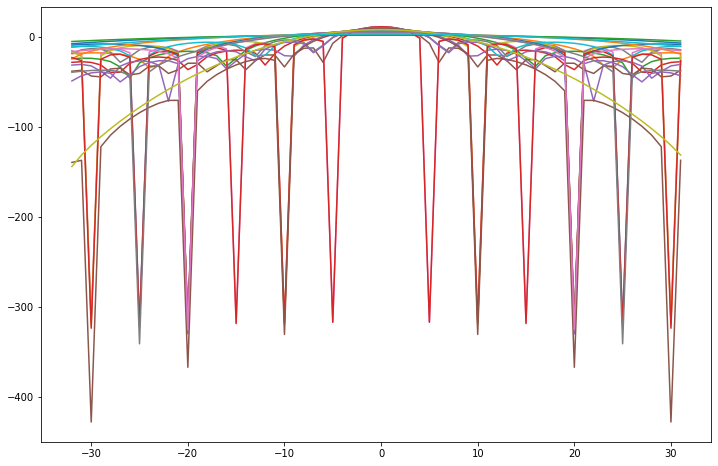

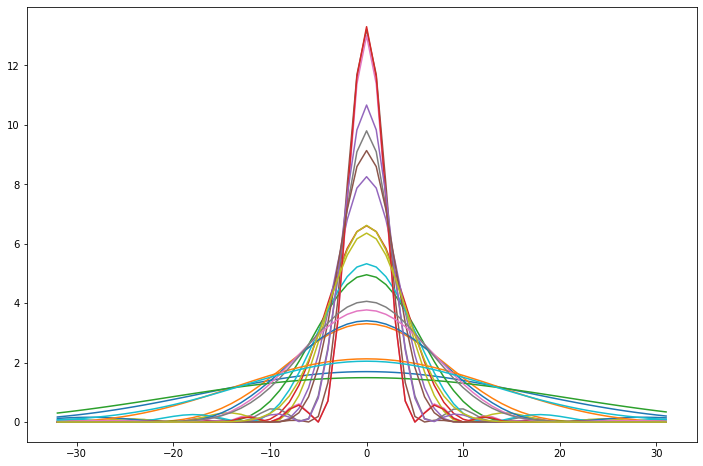

In [ ]:
'''another ploting for stored cleaPSD'''
# Please find Rectangle and Triangular wave in the old version
span = 64
#Generate x axis for ploting
sin_coef = 0.1
xaxis = np.arange(-1*span//2, span//2, 1., dtype =  float)
'''Try loading data and ploting PSD'''
loaded_psd = torch.load(address+name) #'clean_PSD.pth'
plt.figure()
for i in range(20):
  plt.plot( xaxis, 10*np.log10( loaded_psd[i+1] ) )

plt.figure()
for i in range(20):
  plt.plot( xaxis,  loaded_psd[i+1]  )

In [ ]:
#Check GPU settings
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

Not connected to a GPU


In [ ]:
# Old version, not random single PSD at each example. Load cleanPSD library(dict)
#Set address, either on local(virtual machine) or mounted on drive,
#If mounted to drive and will save the clean PSDs to drive
address = '/content/drive/MyDrive/Wireless_Transformer/'
name = 'clean_PSD_6mod_Mat.pth'
cleanPSD = torch.load(address+name) # load saved clean PSDs
#Check saved PSDs
print(cleanPSD['Description'])

'''Main signal and label list generation, to be finished'''
amp = np.ones(10) #8 # channel gain, currently identical
sig_list = [1,2,3,2,1,4,5,6,5,4] # Sep 9, left&right independent,
num_band = len(sig_list)
assign_dict = {      #bands assigned to each PU
              # Sep9 version, left&right independent
    'description': 'DataSep9,'+name,
    'nPU': 6,
    'PU1': [1,5],
    'PU2': [2,4],
    'PU3': [3],
    'PU4': [6,10],
    'PU5': [7,9],
    'PU6': [8],
        }

'''Oct24 No-bonding-bands '''
# assign_dict = {      #Oct24 No-bonding-bands
#     'description': 'DataOct24, No-bonding,'+name,
#     'nPU': 10,
#     'PU1': [1],'PU2': [2],'PU3': [3],'PU4': [4],'PU5': [5],'PU6': [6],
#     'PU7':[7], 'PU8':[8], 'PU9':[9], 'PU10':[10],
#         }

def data_generator(volum=1, SNR=10, assign_dict=assign_dict, sig_list=sig_list, PSD_lib=cleanPSD, nw = 64 ):
  '''Oct 25 updated for Matlab data
  volum is the num of samples per occupancy pattern,
  SNR (current for single SNR case)
  assign_dict is the PU's band allocation
  sig_list: idx of signal PSDs chosen
  PSD_lib: clean PSDs prepared, normalized pw'''

  nPU = assign_dict['nPU'] #num of PUs
  db_size_list = [ volum for i in range(2**nPU)] #data volume for different occupancy patterns

  spect_list = []
  label_list = []
  for cls in range(2**nPU): # cls: class of occupancy, decided by active PUs, make "volum" input instances for each cls
    #firstly, generate PSDclean, the input data without noise
    label = torch.zeros(len(sig_list)) # create empty label tensor
    PSDclean = torch.zeros(len(sig_list), nw)
    for PU in range(nPU): #for each PU
      if cls & 2**PU: # if True then this PU active
        for band_idx in assign_dict['PU'+str(PU+1)]: # band list assigned to this PU
          PSD_LMR = PSD_lib[sig_list[band_idx-1]][  random.randrange(10)  ]#randomly pick a PSD of this mod, contain left/right leakage
          PSD_L=torch.tensor(PSD_LMR[0:64])
          PSD_M=torch.tensor(PSD_LMR[64:128])
          PSD_R=torch.tensor(PSD_LMR[-64:192])
          # print('PSD_M size', torch.tensor(PSD_M).size() )
          # print('PSD clean sizes',PSDclean.size(),PSDclean[band_idx-1].size())
          PSDclean[band_idx-1] += torch.squeeze(PSD_M)#take the middle 64 digits
          label[band_idx-1] = 1 #set label
          if band_idx>1: #if not left edge
            PSDclean[band_idx-2] += torch.squeeze(PSD_L)
          if band_idx<len(sig_list): #if not right edge
            PSDclean[band_idx] += torch.squeeze(PSD_R)

    label_list += [label] * db_size_list[cls]# prepare labels for the same occupy cls
    # loop to add random noise to clean PSD with specific occupancy pattern
    for n in range(db_size_list[cls]): # then repeat for examples in "cls" occupancy pattern
      spect_list.append( torch.abs( PSDclean + torch.randn_like(PSDclean)*10**(-1*SNR/10) ).view(nw*len(sig_list)) )

  return (spect_list, label_list)

def setDir(filepath):
  # if directory not exist, create. if directory already exist, empty it.
  if not os.path.exists(filepath):
    os.mkdir(filepath)
  else:
    shutil.rmtree(filepath, ignore_errors = True)
    os.mkdir(filepath)

from Matlab, PSD of 6 narrowband sig (4 PSKs, FSK, QAM), length =64, type is 1D numpy ndarray tensor. each key has a list of 10 set 192-dim PSDs
